---
title: "Aplicação de Dummies: Desvendando o Desempenho no ENADE com Regressão Múltipla"
subtitle: "Um Guia Prático para Modelagem Econométrica"
date: 11-12-2025
author: "Gabriel Sathler Victer Itaborahy"
lang: pt-BR
section-divs: true
image: "image.png"
---

Material apresentado na disciplina de Econometria do Curso de Ciencias Econômicas - PUC Minas

[**LINK: Currículo e demais redes**](https://linktr.ee/gabrielsathler)

## **1. Introdução**

Este material didático foi criado com objetivo de dar um exemplo prático aos alunos de econometria a respeito a utilização de variáveis **`DUMMY`**

### 1.1. O Problema: O que explica a nota no ENADE?

Neste guia, investigaremos quais fatores socioeconômicos e comportamentais influenciam a nota dos estudantes de **Ciências Econômicas** em **Universidades** no Exame Nacional de Desempenho dos Estudantes (ENADE) derivado de um projeto de Iniciação Cientifica de própria autoria. Para isso, utilizaremos um modelo de regressão múltipla, com um foco especial na correta especificação de variáveis categóricas.

### 1.2. Preparação do Ambiente e dos Dados

Primeiro, carregamos as bibliotecas necessárias e filtramos nossa base de dados para focar no nosso público de interesse.

In [1]:
#| echo: true
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Ignora warnings para uma saída mais limpa
warnings.simplefilter("ignore")

# Configura o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Carrega e filtra os dados
try:
    df_completo = pd.read_parquet('dataset/01_enade.parquet')
    df_eco = df_completo[df_completo['cod_grupo'] == 13].copy()
    df = df_eco[df_eco['cod_ies_org'] == 1].copy()
    print(f"O DataFrame final contém {df.shape[0]} observações para nossa investigação.")
except FileNotFoundError:
    print("Erro: Arquivo 'dataset/01_enade.parquet' não foi encontrado.")

O DataFrame final contém 28191 observações para nossa investigação.


## **2. O Desafio das Variáveis Categóricas**

Modelos de regressão, como o de Mínimos Quadrados Ordinários (OLS), requerem que todas as variáveis sejam numéricas. No entanto, muitas informações socioeconômicas importantes são, por natureza, categóricas. Simplesmente atribuir números sequenciais (e.g., 1 para a primeira faixa de renda, 2 para a segunda) é uma abordagem incorreta, pois impõe uma relação linear que raramente existe na realidade.

## **3. A Solução: Variáveis Dummy**

**Obs.: Focaremos o exemplo na variável de `Faixa de Renda` neste material mas se aplica as demais variáveis.**

### 3.1. O que são Dummies?

A solução correta é transformar cada categoria em uma **variável dummy** (ou indicadora). Uma dummy é uma variável binária que assume o valor `1` se uma característica está presente e `0` caso contrário.

$D_i = \begin{cases} 1 & \text{se o indivíduo } i \text{ possui a característica} \\ 0 & \text{caso contrário} \end{cases}$

### 3.2. Exemplo Prático: Transformando Variáveis

#### 3.2.1. Exemplo tabela original retirada do questionário:

| Aluno        | Faixa de Renda | Descrição 'Faixa de Renda' |
|--------------|:---------------|----------------------------|
| Gabriel      | A              | **Até 1,5 SM**             |
| Henrique     | B              | De 1,5 a 3 SM              |
| João Marcelo | B              | De 1,5 a 3 SM              |
| Mylla        | D              | De 4,5 a 6 SM              |
| Thiago       | E              | De 6 a 10 SM               |
| Caroline     | F              | De 10 a 30 SM              |
| Pedro        | G              | Acima de 30 SM             |

#### 3.2.2. Transformação do questionário para variáveis numericas ordinais:

Utilizaremos esta variável para fins didáticos posteriormente.

| Aluno        | cod_renda | Descrição 'cod_renda' |
|--------------|:----------|-----------------------|
| Gabriel      | 1         | **Até 1,5 SM**        |
| Henrique     | 2         | De 1,5 a 3 SM         |
| João Marcelo | 2         | De 1,5 a 3 SM         |
| Mylla        | 4         | De 4,5 a 6 SM         |
| Thiago       | 5         | De 6 a 10 SM          |
| Caroline     | 6         | De 10 a 30 SM         |
| Pedro        | 7         | Acima de 30 SM        |

#### 3.2.3. Criação de Dummies

Para ilustrar, vamos ver como as variáveis **Renda Familiar** (7 categorias) e **Situação de Trabalho** (5 categorias) são transformadas.

-   **Renda:** Ref: "Até 1,5 SM". Criamos 6 dummies (`renda_fx2` a `renda_fx7`).
-   **Trabalho:** Ref: "Não trabalha". Criamos 4 dummies (`trab_eventual` a `trab_40h_mais`).

A tabela abaixo mostra como a transformação funciona para estudantes hipotéticos:

| Aluno | Renda Original (Categoria) | renda_fx2 | renda_fx3 | renda_fx4 | renda_fx5 | renda_fx6 | renda_fx7 |
|---------|:--------|:--------|:--------|:--------|:--------|:--------|:--------|
| Gabriel | **Até 1,5 SM (Ref.)** | 0 | 0 | 0 | 0 | 0 | 0 |
| Henrique | De 1,5 a 3 SM | 1 | 0 | 0 | 0 | 0 | 0 |
| João Marcelo | De 1,5 a 3 SM | 1 | 0 | 0 | 0 | 0 | 0 |
| Mylla | De 4,5 a 6 SM | 0 | 0 | 1 | 0 | 0 | 0 |
| Thiago | De 6 a 10 SM | 0 | 0 | 0 | 1 | 0 | 0 |
| Caroline | De 10 a 30 SM | 0 | 0 | 0 | 0 | 1 | 0 |
| Pedro | Acima de 30 SM | 0 | 0 | 0 | 0 | 0 | 1 |

O coeficiente de cada dummy (ex: `renda_fx2`) mede o impacto daquela categoria **em comparação com a categoria de referência**.

### 3.3. A Armadilha da Multicolinearidade

**Regra de Ouro:** Se uma variável possui **k** categorias, criamos apenas **k-1** dummies. Se criarmos dummies para todas as *k* categorias, o modelo se torna inestimável devido à **multicolinearidade perfeita**.

## **4. Construção e Análise dos Modelos**

Para fins didáticos, utilizaremos o modelo de regressão com estimadores de MQO (Mínimos Quadrados Ordinários).

***Obs.:***
*`O estimador robusto utilizado originalmente na pesquisa que melhor se adequa ao comportamento dos dados não será aplicado neste exemplo.`*

### 4.1. O Modelo Teórico Completo

Nosso objetivo é modelar a nota geral ($Nota_i$) do estudante $i$ como uma função de todas as nossas características selecionadas, de forma explícita:

```{=latex}
\begin{align}
Nota_i = \beta_0 & + \alpha_1 \text{PessoasRes}_i \\
& + \theta_1 \text{GeneroFem}\_i \\
& + \beta_2 \text{Preta}_i + \beta_3 \text{Parda}_i \\
& + \delta_2 \text{Renda}_2 + \delta_3 \text{Renda}_3 + \delta_4 \text{Renda}_4 + \delta_5 \text{Renda}_5 + \delta_6 \text{Renda}_6 + \delta_7 \text{Renda}_7 \\
& + \gamma_1 \text{TrabEventual} + \gamma_2 \text{Trab20h} + \gamma_3 \text{Trab39h} + \gamma_4 \text{Trab40h+} \\
& + \zeta_1 \text{Estudo3h} + \zeta_2 \text{Estudo7h} + \zeta_3 \text{Estudo12h} + \zeta_4 \text{Estudo12h+} \\
& + \eta_1 \text{Leitura2} + \eta_2 \text{Leitura5} + \eta_3 \text{Leitura8} + \eta_4 \text{Leitura8+} \\
& + \lambda_1 \text{EMMaioriaPub} + \lambda_2 \text{EMMetadePub} + \lambda_3 \text{EMMaioriaPriv} \\
& + \lambda_4 \text{EMTotalPriv} + \lambda_5 \text{EMExterior} + \epsilon_i
\end{align}
```

### 4.2. Modelo 1: A Abordagem Correta (com Dummies)

Primeiro, estimamos o modelo de regressão utilizando o conjunto completo de dummies.

In [2]:
# Preparação dos Dados
y_var = 'nt_ger'
x_vars_dummies = [
    'cod_pessoas_res', 
    'genero_fem',
    'cor_preta', 'cor_parda',
    'renda_fx2', 'renda_fx3', 'renda_fx4', 'renda_fx5', 'renda_fx6', 'renda_fx7',
    'trab_eventual', 'trab_ate20h', 'trab_21a39h', 'trab_40h_mais',
    'hestudo_1a3h', 'hestudo_4a7h', 'hestudo_8a12h', 'hestudo_mais12h',
    'leitura_1a2', 'leitura_3a5', 'leitura_6a8', 'leitura_mais8',
    'em_maioria_pub', 'em_metade_pub', 'em_maioria_priv', 'em_total_priv', 'em_brasil_exterior'
]
df_reg = df[[y_var] + x_vars_dummies].copy().dropna()
y = df_reg[y_var]
X_dummies = sm.add_constant(df_reg[x_vars_dummies])

# Estimação do Modelo
modelo_ols = sm.OLS(y, X_dummies)
resultados_ols = modelo_ols.fit()
print(resultados_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 nt_ger   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     93.19
Date:                Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:13:18   Log-Likelihood:            -1.0054e+05
No. Observations:               25077   AIC:                         2.011e+05
Df Residuals:                   25049   BIC:                         2.014e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 34.5236      0

#### 4.2.1 O Modelo Estimado com Coeficientes

A partir da tabela acima, podemos construir a equação do modelo estimado, agora representando todas as variáveis:

```{=latex}
\begin{align}
\widehat{Nota_i} = 36.38 & - 0.86 \cdot \text{PessoasRes}_i \\
& - 3.25 \cdot \text{GeneroFem} \\
& - 1.71 \cdot \text{Preta}_i - 1.30 \cdot \text{Parda}_i \\
& + 1.39 \cdot \text{Renda}_2 + 2.90 \cdot \text{Renda}_3 + 3.80 \cdot \text{Renda}_4 + 5.00 \cdot \text{Renda}_5 + 6.70 \cdot \text{Renda}_6 + 6.89 \cdot \text{Renda}_7 \\
& - 2.43 \cdot \text{TrabEventual} - 1.40 \cdot \text{Trab20h} - 2.11 \cdot \text{Trab39h} - 3.02 \cdot \text{Trab40h+} \\
& + 1.39 \cdot \text{Estudo3h} + 3.98 \cdot \text{Estudo7h} + 5.59 \cdot \text{Estudo12h} + 7.37 \cdot \text{Estudo12h+} \\
& + 0.48 \cdot \text{Leitura2} + 0.99 \cdot \text{Leitura5} + 1.79 \cdot \text{Leitura8} + 1.29 \cdot \text{Leitura8+} \\
& - 1.64 \cdot \text{EMMaioriaPub} - 6.27 \cdot \text{EMMetadePub} - 1.58 \cdot \text{EMMaioriaPriv} \\
& + 0.16 \cdot \text{EMTotalPriv} + 5.70 \cdot \text{EMExterior}
\end{align}
```

#### 4.2.2 Interpretando os Coeficientes de Renda

O gráfico abaixo mostra o valor do coeficiente para cada dummy de renda.

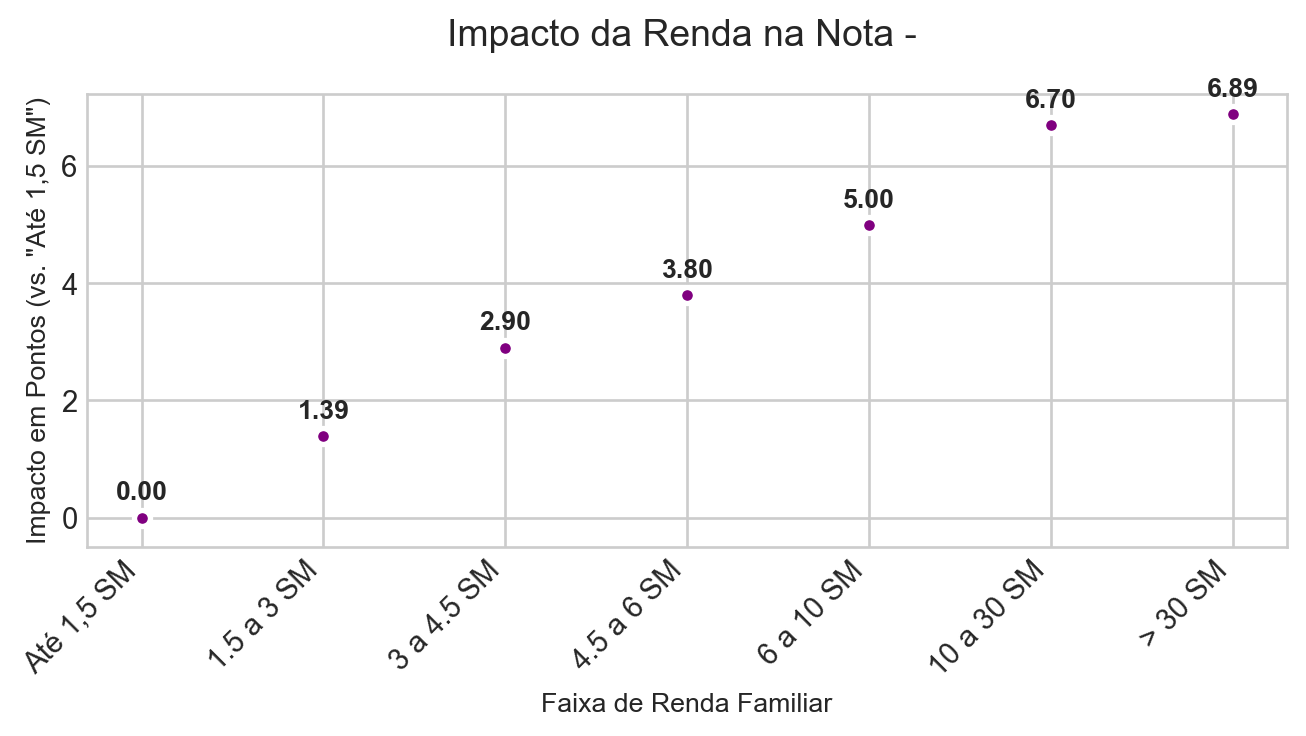

In [3]:
coefs_renda = resultados_ols.params.filter(like='renda_fx') 
coefs_renda.index = ['1.5 a 3 SM', '3 a 4.5 SM', '4.5 a 6 SM', '6 a 10 SM', '10 a 30 SM', '> 30 SM']

# 2. Adicionar a categoria de referência (impacto 0) para uma visualização completa
# A categoria base (renda_fx1) tem um coeficiente de 0 por definição.
dados_plot = pd.Series({'Até 1,5 SM': 0.0})
# Adicionar os outros coeficientes com seus respectivos rótulos
novos_indices = ['1.5 a 3 SM', '3 a 4.5 SM', '4.5 a 6 SM', '6 a 10 SM', '10 a 30 SM', '> 30 SM']
coefs_renda.index = novos_indices
dados_plot = pd.concat([dados_plot, coefs_renda])

# 3. Criar o gráfico de linha
plt.style.use('seaborn-v0_8-whitegrid') # Um estilo que favorece gráficos de linha
plt.figure(figsize=(7, 4))

# Usar sns.lineplot e adicionar marcadores ('o') para destacar cada ponto
sns.scatterplot(x=dados_plot.index, y=dados_plot.values, marker='o', color='purple', lw=2)
plt.title('Impacto da Renda na Nota - ', fontsize=14, pad=18)
plt.ylabel('Impacto em Pontos (vs. "Até 1,5 SM")', fontsize=10)
plt.xlabel('Faixa de Renda Familiar', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=-0.5) # Garante que a linha do eixo x (valor 0) seja visível

# 4. Adicionar os valores em cada ponto do gráfico
for x, y in zip(dados_plot.index, dados_plot.values):
    # Adiciona o texto um pouco acima do ponto para melhor visualização
    plt.text(x=x, y=y + 0.3, s=f'{y:.2f}', ha='center', fontsize=10, weight='bold')

plt.tight_layout() # Ajusta o layout para evitar que os rótulos sejam cortados
plt.show()

O modelo com dummies nos permite ver que o "salto" de uma faixa para outra não é constante. Podemos calcular o efeito marginal de mudar de uma faixa para a imediatamente superior:

\begin{align}
\Delta \text{Efeito(Renda 2 vs 1)} &= \hat{\delta}_2 = 1.39 \\
\Delta \text{Efeito(Renda 3 vs 2)} &= \hat{\delta}_3 - \hat{\delta}_2 = 2.90 - 1.39 = 1.51 \\
\Delta \text{Efeito(Renda 4 vs 3)} &= \hat{\delta}_4 - \hat{\delta}_3 = 3.80 - 2.90 = 0.90 \\
\Delta \text{Efeito(Renda 5 vs 4)} &= \hat{\delta}_5 - \hat{\delta}_4 = 5.00 - 3.80 = 1.20 \\
\Delta \text{Efeito(Renda 6 vs 5)} &= \hat{\delta}_6 - \hat{\delta}_5 = 6.70 - 5.00 = 1.70 \\
\Delta \text{Efeito(Renda 7 vs 6)} &= \hat{\delta}_7 - \hat{\delta}_6 = 6.89 - 6.70 = 0.19
\end{align}

Isso mostra claramente a relação não-linear que o modelo ordinal não conseguiria capturar.

### 4.3. Modelo 2: Um Erro Didático (Renda como Variável Ordinal)

Um erro comum é pensar que as variáveis por apresntarem um comportamento aparentemente ordinal, podem ser analisada como uma variável ordinal conforme feito anteriormente com a vaariável `cod_renda`. Porém isto é um metódo errado que explicaremos a seguir.

Para fins de comparação, estimamos o modelo incorreto utilizando variáveis de forma ordinal.

In [4]:
# Variáveis para Modelo Ordinal
x_vars_ordinal = [
    'cod_pessoas_res', 
    'cor_preta', 'cor_parda', 
    'genero_fem',
    'cod_renda',
    'cod_trabalho',
    'cod_hestudo', 
    'cod_leitura',
    'em_maioria_pub', 'em_metade_pub', 'em_maioria_priv', 'em_total_priv', 'em_brasil_exterior'
]

# Preparar dados
df_reg_ord = df[[y_var] + x_vars_ordinal].copy().dropna()
y_ord = df_reg_ord[y_var]
X_ordinal = sm.add_constant(df_reg_ord[x_vars_ordinal])

# Estimar modelo
modelo_ols_ordinal = sm.OLS(y_ord, X_ordinal)
resultados_ols_ordinal = modelo_ols_ordinal.fit()
print(resultados_ols_ordinal.summary())

                            OLS Regression Results                            
Dep. Variable:                 nt_ger   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     189.1
Date:                Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:13:18   Log-Likelihood:                -97921.
No. Observations:               24448   AIC:                         1.959e+05
Df Residuals:                   24434   BIC:                         1.960e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 33.2431      0

#### 4.2.1 O Modelo Estimado com Coeficientes

A partir da tabela acima, podemos construir a equação do modelo estimado, agora representando todas as variáveis:

```{=latex}
\begin{align}
\widehat{Nota_i} = 33.59 & - 0.83 \cdot \text{PessoasRes}_i \\
& - 3.31 \cdot \text{GeneroFem}_i \\
& - 1.45 \cdot \text{Preta}_i - 0.69 \cdot \text{Parda}_i \\
& + 1.25 \cdot \text{FaixaRenda}_i \\
& - 0.74 \cdot \text{Trabalho}_i \\
& + 1.98 \cdot \text{HorasEstudo}_i \\
& + 0.36 \cdot \text{HorasLeitura}_i \\
& - 1.64 \cdot \text{EMMaioriaPub}_i - 6.27 \cdot \text{EMMetadePub} - 1.58 \cdot \text{EMMaioriaPriv} \\
& + 0.16 \cdot \text{EMTotalPriv} + 5.70 \cdot \text{EMExterior}
\end{align}
```

**Interpretação do Coeficiente Faixa de Renda:**

\begin{align}
\Delta \text{Faixa de Renda} &= \hat{\delta} = + 1.25 \\
\end{align}

A interpretação do coeficiente desta variável indica que a cada aumento de +1 na `Faixa de Renda` a pontuação cresce em + 1.25.

## **5. O Veredito: Comparando os Modelos**

Os gráficos a seguir ilustram a diferença fundamental entre as duas abordagens, agora empilhados verticalmente para melhor visualização.

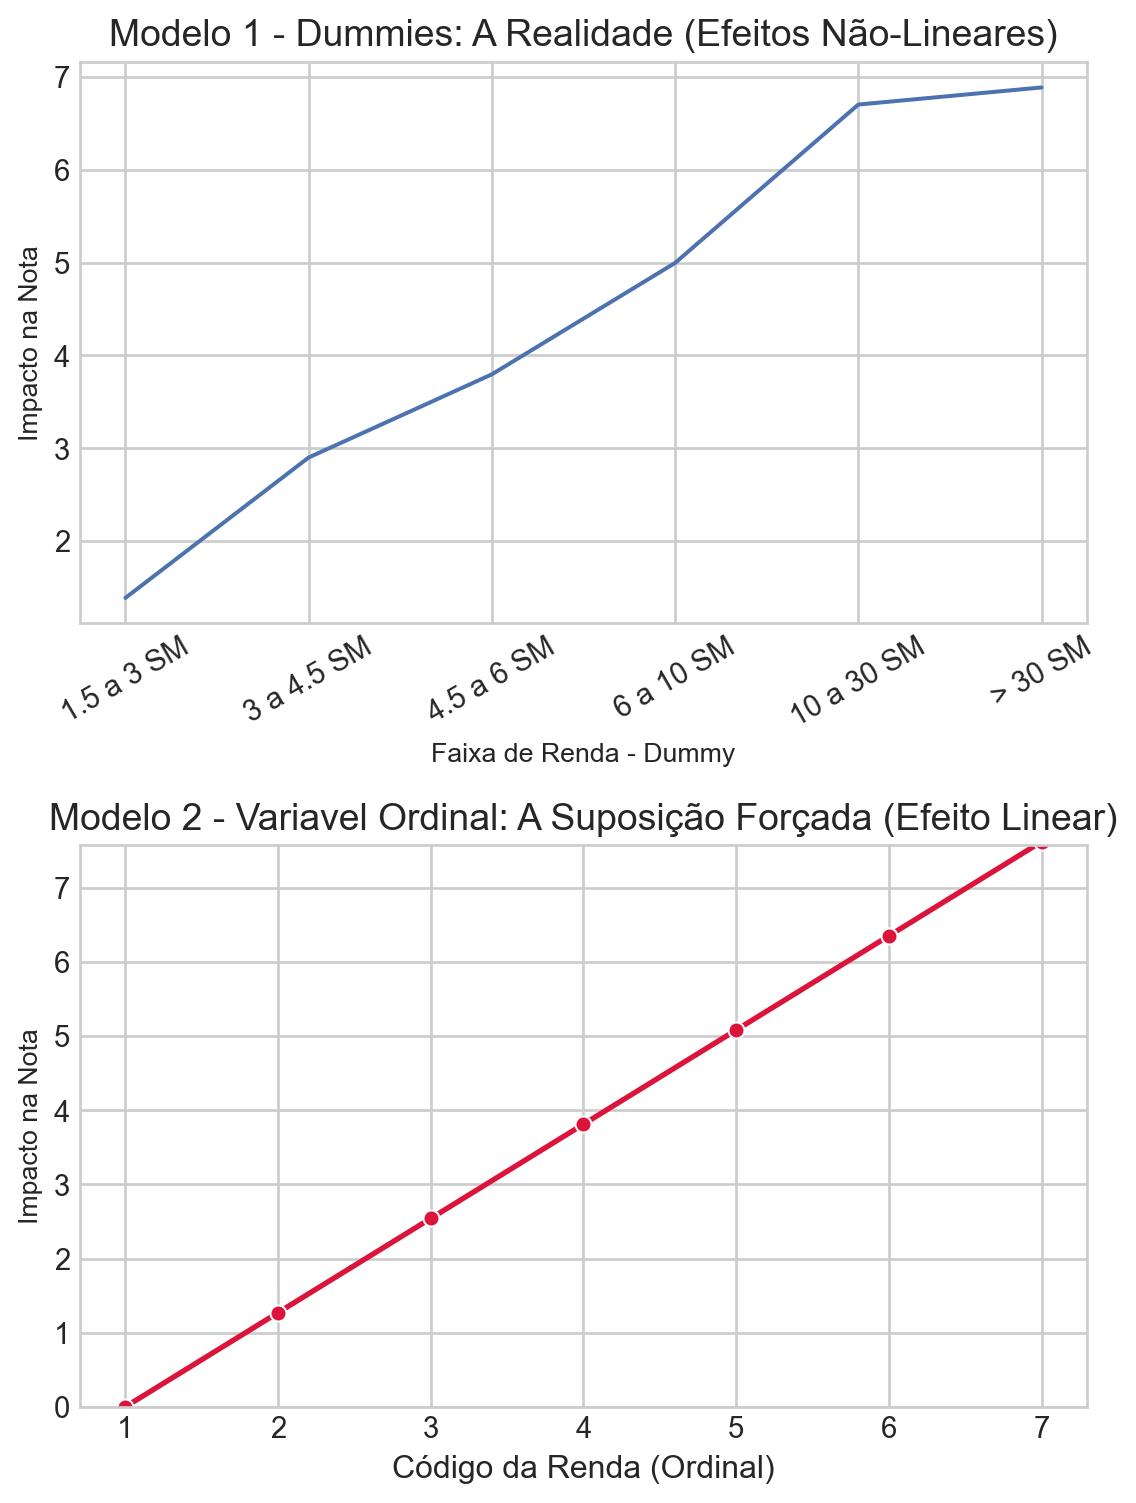

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico 1: Realidade (Dummies)
sns.lineplot(ax=axes[0], x=coefs_renda.index, y=coefs_renda.values, palette='viridis')
axes[0].set_title('Modelo 1 - Dummies: A Realidade (Efeitos Não-Lineares)', fontsize=14)
axes[0].set_xlabel('Faixa de Renda - Dummy', fontsize=10)
axes[0].set_ylabel('Impacto na Nota', fontsize=10)
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=30)


# Gráfico 2: Suposição Forçada (Ordinal)
x_vals = np.arange(1, 8)
y_vals = resultados_ols_ordinal.params['cod_renda'] * (x_vals - 1)
sns.lineplot(ax=axes[1], x=x_vals, y=y_vals, marker='o', color='crimson', lw=2)
axes[1].set_title('Modelo 2 - Variavel Ordinal: A Suposição Forçada (Efeito Linear)', fontsize=14)
axes[1].set_xlabel('Código da Renda (Ordinal)', fontsize=12)
axes[1].set_ylabel('Impacto na Nota', fontsize=10)
axes[1].grid(True)
axes[1].set_ylim(0, max(coefs_renda.values) * 1.1)

plt.tight_layout()
plt.show()

Pode ver que o modelo que utiliza a varavel `Faixa de Renda` de forma ordinal não consegue capturar com exatidão o impacto da variável na nota.

## 6. Conclusões

-   **Dummies são Essenciais:** São a forma correta de incluir variáveis categóricas em modelos de regressão.
-   **A Regra do k-1:** Lembre-se sempre de omitir uma categoria de referência para evitar a multicolinearidade.
-   **A Realidade não é Linear:** O uso de dummies permite que o modelo capture os efeitos não-lineares que são comuns em fenômenos socioeconômicos.
-   **Insights do ENADE:** Fatores como renda, horas de estudo e desigualdades estruturais são preditores estatisticamente significantes do desempenho acadêmico.